In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import  fixed
import ipywidgets as widgets
import ipywidgets as interactive
plt.rcParams['figure.figsize'] = [16,8]
from IPython.display import clear_output

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def fmt(x):
    if x >= 10**6:
        return f'{x/10**6:.1f}M'
    elif x >= 10**3:
        return f'{x/10**3:.1f}K'
    else:
        return f'{x:.0f}'

def convert_from_seconds(sec, to = 'days'):
    sec = sec.total_seconds()
    match to:
        case 'months':
            return sec / 60 / 60 / 24 / 30
        case 'days':
            return sec / 60 / 60 / 24
        case 'hours':
            return sec / 60 / 60
        case 'minutes':
            return sec / 60
        case 'seconds':
            return sec
        case _:
            raise ValueError(f'Unknown unit {to}')

def assign_grouping(value,values):
  for group in values:
    if group in value:
      return group
  return 'Other'

In [3]:
df_orig = pd.read_csv('311.csv', low_memory=False)

In [4]:
df = df_orig.copy(deep=True)

In [5]:
df['open_dt'] = pd.to_datetime(df['open_dt'],format='%Y-%m-%d %H:%M:%S')
df['sla_target_dt'] = pd.to_datetime(df['sla_target_dt'],format='%Y-%m-%d %H:%M:%S')
df['closed_dt'] = pd.to_datetime(df['closed_dt'],format='%Y-%m-%d %H:%M:%S')

In [6]:
from datetime import timedelta
df['resolution_time'] = df['closed_dt'] - df['open_dt'] # add new column for resolution time
df['resolution_time'].describe()
df.loc[df['resolution_time'] < timedelta(0),'resolution_time'] = timedelta(seconds=0) # replace negative resolution times with 0

In [7]:
df['neighborhood'] = df['neighborhood'].fillna(' ')
# now replace all ' ' values with 'No Neighborhood'
df.loc[df.neighborhood == ' ','neighborhood'] = 'No Neighborhood Data'

In [8]:
year_range = df.open_dt.dt.year.agg(['min','max'])
year_min = year_range['min']
year_max = year_range['max']

In [9]:
df['resolution_time_days'] = df['resolution_time'].dt.days
df['resolution_time_days'] = df['resolution_time_days'].clip(lower=0).fillna(0).astype(int)

In [10]:
group_to_reasons = {
    'Public Works and Infrastructure': ['Street Lights', 'Highway Maintenance', 'Street Cleaning', 'Graffiti', 
                                        'Enforcement & Abandoned Vehicles', 'Trees', 'Park Maintenance & Safety', 
                                        'Abandoned Bicycle', 'Traffic Management & Engineering', 'Cemetery', 
                                        'Bridge Maintenance', 'Catchbasin', 'Water Issues', 'Fire Hydrant', 
                                        'Sidewalk Cover / Manhole', 'Pothole'],
    'Sanitation and Environmental Services': ['Sanitation', 'Recycling', 'Environmental Services', 'Air Pollution Control'],
    'Urban Maintenance and Safety': ['Signs & Signals', 'Building', 'Housing', 'Weights and Measures', 
                                     'Code Enforcement', 'Valet', 'Parking Complaints', 'Fire Department', 
                                     'Neighborhood Services Issues', 'Generic Noise Disturbance', 'Noise Disturbance'],
    'Administrative and General Services': ['Notification', 'Employee & General Comments', 'Administrative & General Requests', 
                                            'Operations', 'Office of The Parking Clerk', 'Programs', 'Billing', 
                                            'MBTA', 'General Request', 'Administrative', 'Disability', 
                                            'Consumer Affairs Issues', 'Call Center Intake', 'Boston Bikes'],
    'Health and Public Safety': ['Health', 'Animal Issues', 'Needle Program'],
    'Community and Cultural Services': ['Volunteer & Corporate Groups', 'Alert Boston', 'Current Events', 
                                        'Massport', 'Hero Square Sign'],
    'Testing': ['Test Cases']
}

reason_to_group = {reason: group for group, reasons in group_to_reasons.items() for reason in reasons}

def map_reason_to_group(reason):
    return reason_to_group.get(reason)  

df['reason_grouped'] = df['reason'].apply(map_reason_to_group)

In [11]:
df.columns

Index(['case_enquiry_id', 'open_dt', 'sla_target_dt', 'closed_dt', 'on_time',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submitted_photo', 'closed_photo',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'geom_4326', 'source', 'resolution_time',
       'resolution_time_days', 'reason_grouped'],
      dtype='object')

Without testing

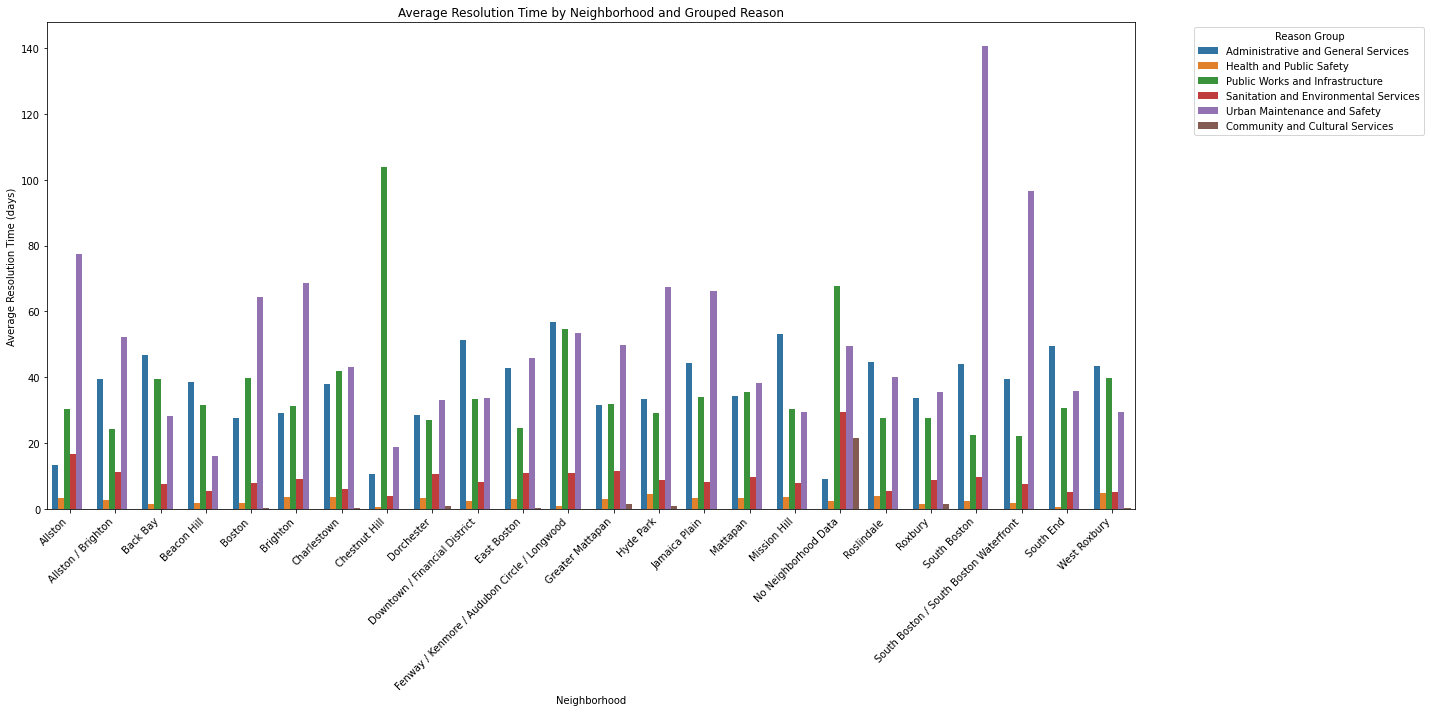

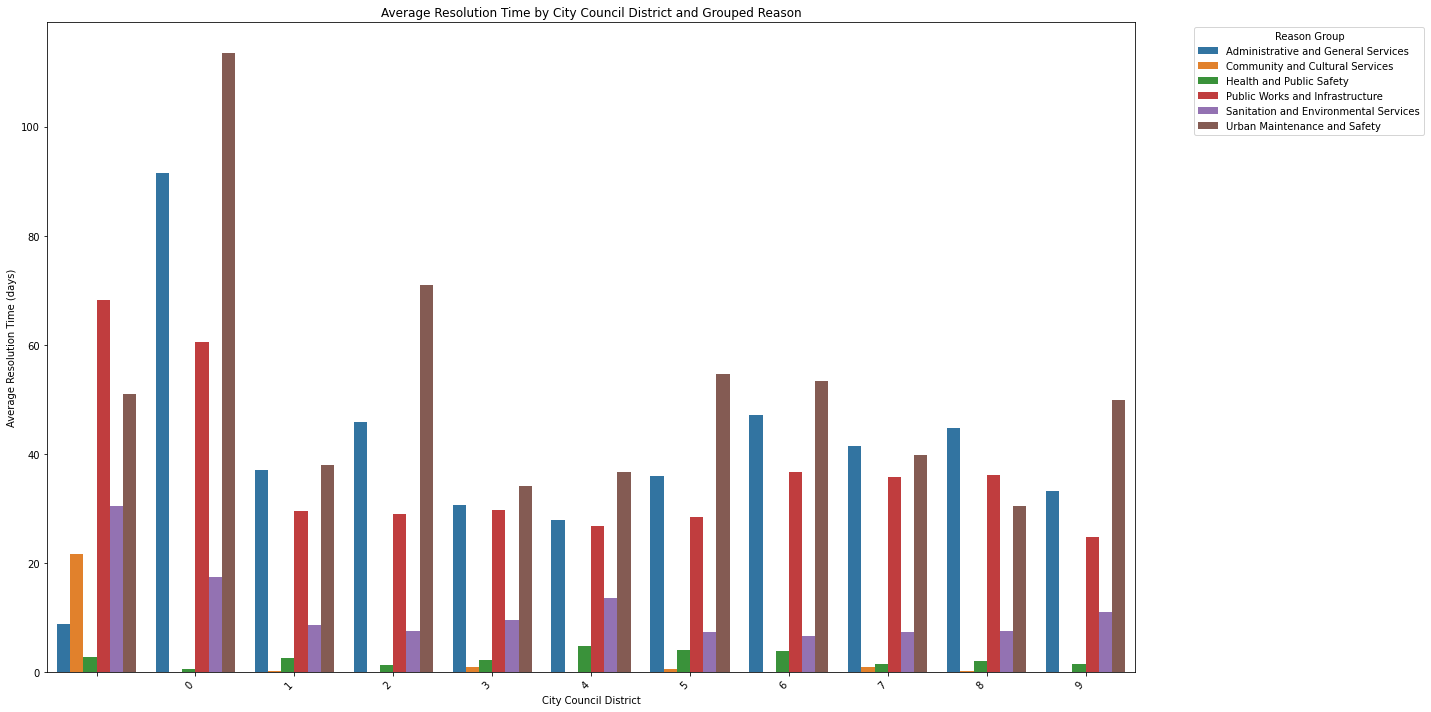

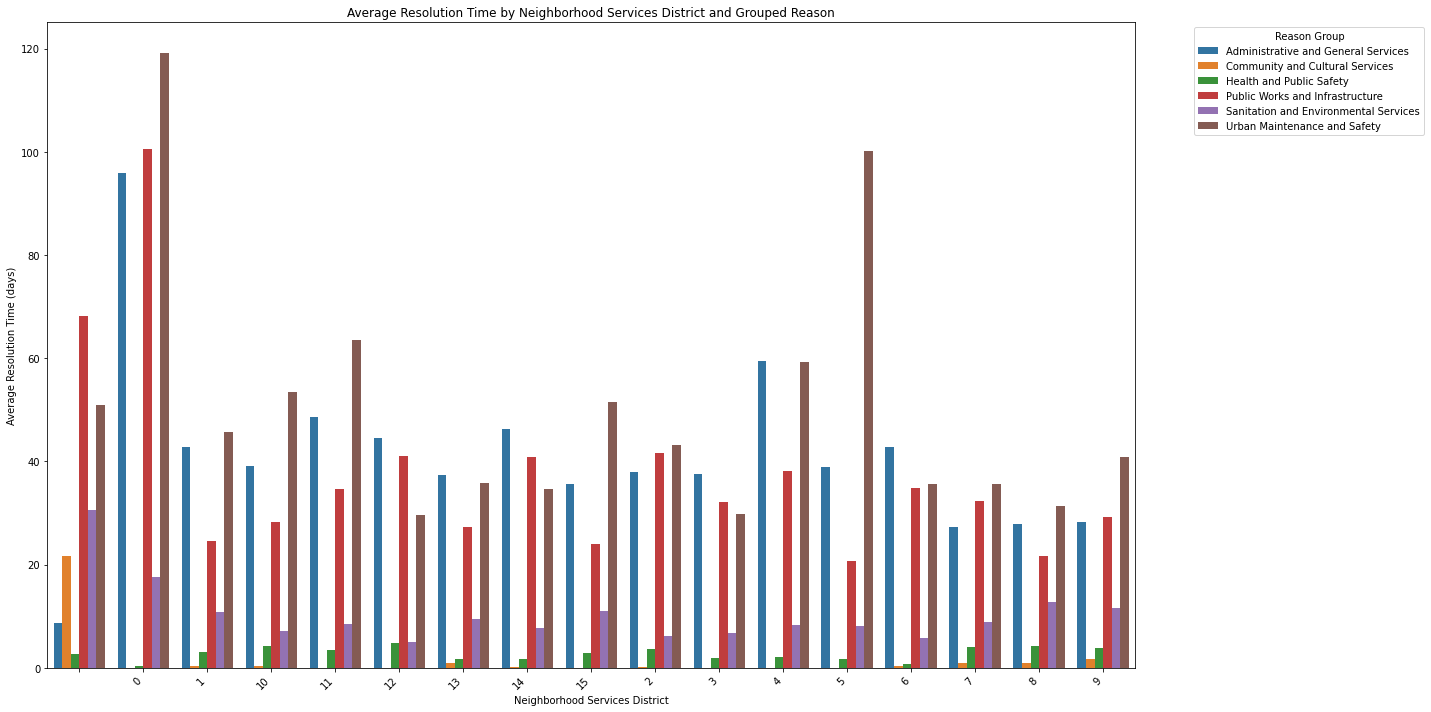

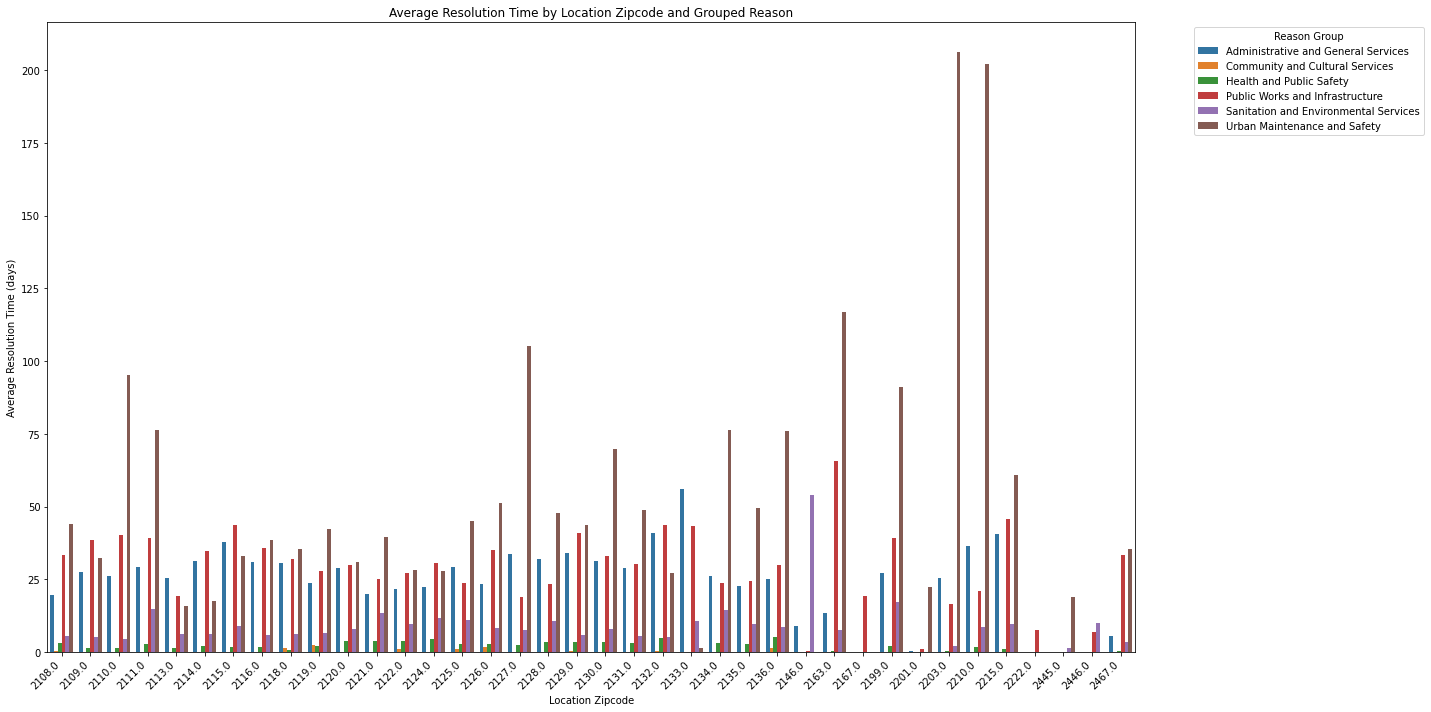

In [16]:
df_filtered = df[df['reason_grouped'] != 'Testing']

categories = ['neighborhood', 'city_council_district', 'neighborhood_services_district', 'location_zipcode']

for category in categories:
    grouped_df = df_filtered.groupby([category, 'reason_grouped'])['resolution_time_days'].mean().reset_index()

    plt.figure(figsize=(20, 10))
    sns.barplot(x=category, y='resolution_time_days', hue='reason_grouped', data=grouped_df, dodge= True)

    plt.xticks(rotation=45, horizontalalignment='right')

    plt.title(f'Average Resolution Time by {category.replace("_", " ").title()} and Grouped Reason')
    plt.ylabel('Average Resolution Time (days)')
    plt.xlabel(category.replace("_", " ").title())
    plt.legend(title='Reason Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout() 
    plt.show()

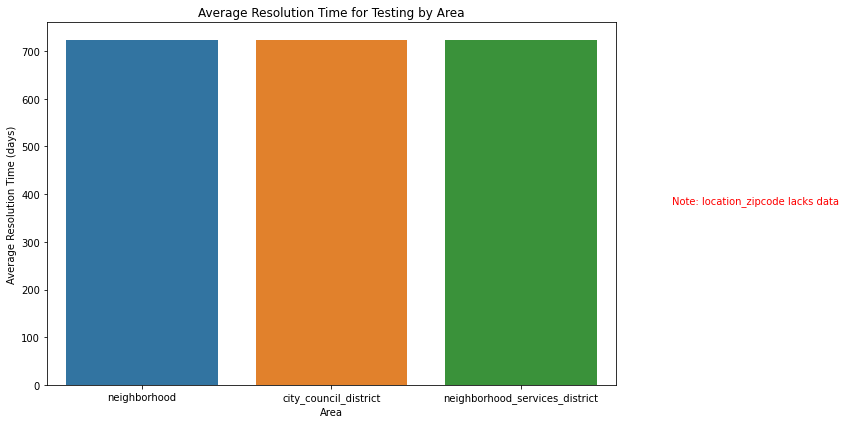

In [ ]:
df_filtered = df[df['reason_grouped'] == 'Testing']

categories = ['neighborhood', 'city_council_district', 'neighborhood_services_district']

avg_resolution_times_data = []

for category in categories:
    avg_time = df_filtered.groupby(category)['resolution_time_days'].mean().mean()

    avg_resolution_times_data.append({'Area': category, 'Average Resolution Time (days)': avg_time})

avg_resolution_times = pd.DataFrame(avg_resolution_times_data)

plt.figure(figsize=(12, 6))
sns.barplot(x='Area', y='Average Resolution Time (days)', data=avg_resolution_times)

plt.title('Average Resolution Time for Testing by Area')
plt.ylabel('Average Resolution Time (days)')
plt.xlabel('Area')

plt.text(x=1.1, y=0.5, s="Note: location_zipcode lacks data", 
         horizontalalignment='left', transform=plt.gca().transAxes, color='red', fontsize=10)

plt.tight_layout()
plt.show()